In [1]:
from keras import Model
from keras.layers import AveragePooling2D, Flatten, Dropout, Dense, Conv2D, \
    MaxPooling2D, Input, concatenate, BatchNormalization

Using TensorFlow backend.


In [2]:
# Inception 模块
def inception_module(img, params):
    """
    Inception 模块
    :param img:
    :param params:
    :return:
    """

    (branch1, branch2, branch3, branch4) = params

    # 1x1
    pathway1 = Conv2D(branch1[0], kernel_size=(1, 1))(img)

    # 1x1->3x3
    pathway2 = Conv2D(branch2[0], kernel_size=(1, 1), padding='same')(img)
    pathway2 = Conv2D(branch2[1], kernel_size=(3, 3), padding='same')(pathway2)

    # 1x1->5x5
    pathway3 = Conv2D(branch3[0], kernel_size=(1, 1), padding='same')(img)
    pathway3 = Conv2D(branch3[1], kernel_size=(5, 5), padding='same')(pathway3)

    # 3x3->1x1
    pathway4 = MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(img)
    pathway4 = Conv2D(branch4[0], kernel_size=(1, 1), padding='same')(pathway4)

    return concatenate([pathway1, pathway2, pathway3, pathway4], axis=3)


In [3]:
# 创建模型
# 使用函数式API

input_tensor = Input(shape=(400,100,3))
print(1)

x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_tensor)
print(1.5)
x = MaxPooling2D(pool_size=(3, 3),strides=2, padding='same')(x)
x = BatchNormalization()(x)
print(2)
x = Conv2D(64, (1, 1),padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3),padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3),strides=2, padding='same')(x)
print(3)
x = inception_module(x, params=[(64,), (96, 128), (16, 32), (32,)])
print(3.5)
x = inception_module(x, params=[(128,), (128, 192), (32, 96), (64,)])
print(4)
x = MaxPooling2D(pool_size=(3, 3),strides=2, padding='same')(x)





x=inception_module(x,params=[(192,),(96,208),(16,48),(64,)]) #4a
x=inception_module(x,params=[(160,),(112,224),(24,64),(64,)]) #4b
x=inception_module(x,params=[(128,),(128,256),(24,64),(64,)]) #4c
x=inception_module(x,params=[(112,),(144,288),(32,64),(64,)]) #4d
x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)]) #4e
x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)]) #5a
x=inception_module(x,params=[(384,),(192,384),(48,128),(128,)]) #5b



x = AveragePooling2D(pool_size=(13, 4))(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(1, activation='sigmoid')(x)
print(5)
model = Model(input_tensor, output_tensor)
model.summary()

1
1.5
2
3
3.5
4
5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 50, 64)  9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 100, 25, 64)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 25, 64)  256         max_pooling2d_1[0][0]            
__________________________________________________________________________

In [5]:
#配置模型的损失函数、优化器、指标名称

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])


In [6]:
#图片的训练路径和验证路径
train_dir = r'G:\useful_L\Normal3\NEW_NET_2.0\train'
val_dir = r'G:\useful_L\Normal3\NEW_NET_2.0\val'

In [7]:
#生成训练需要的图片和标签
from keras.preprocessing.image import ImageDataGenerator
#将图片大小调整到1以内，原先图片每个像素的格式为uint8，所以要除以255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#根据目录的名称，生成对应的标签
#train_dir有Ⅱ型和Ⅲ型的图片
#每次生成batch_size数量的图片，图片大小为target_size
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(400, 100),              #生成图片的大小
batch_size=20,                       #一次生成图片的数量
class_mode='binary')                 #图片标签的类型

validation_generator = val_datagen.flow_from_directory(
val_dir,
target_size=(400, 100),              #生成图片的大小
batch_size=10,                       #一次生成图片的数量
class_mode='binary')                 #图片标签的类型


Found 3480 images belonging to 2 classes.
Found 1460 images belonging to 2 classes.


In [8]:
# 训练时保留验证精度最高的模型

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='Inception-Net_best.h5',monitor='val_acc',mode='auto' ,save_best_only='True')

history = model.fit_generator(
train_generator,                           #通过生成器传入图片和标签
steps_per_epoch=137,                      #分87*2次传入，每次20张
epochs=50,                                 #总共训练40轮
validation_data=validation_generator,      #通过生成器传入图片和标签进行验证
validation_steps=120,                     #分74*2次传入，每次10张
callbacks = [checkpoint]                   # 保留最好的模型
)

Epoch 1/50
137/137 [==============================] - 346s 3s/step - loss: 58.3305 - acc: 0.7423 - val_loss: 1.8410 - val_acc: 0.2583

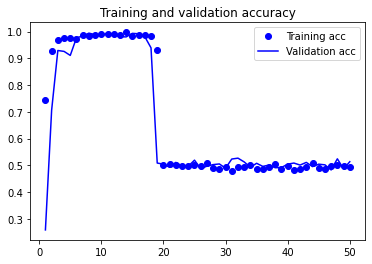

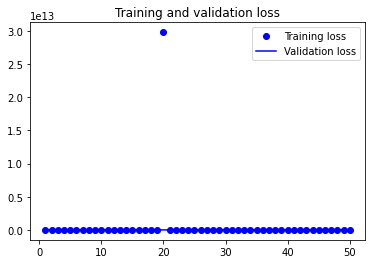

In [9]:
#绘制训练精度、验证精度
#绘制训练损失、验证损失
#python画图库，类似matlab的plot
import matplotlib.pyplot as plt
acc = history.history['acc']             #得到训练的指标数据
val_acc = history.history['val_acc']     #得到验证的指标数据
loss = history.history['loss']           #得到训练损失
val_loss = history.history['val_loss']   #得到验证损失
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('实验1.1_accuracy_50.png')
plt.legend()                              #画图例
plt.figure()                              #另一张图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('实验1.1_loss_50.png')
plt.legend()
plt.show()                                #画图，最后加上

In [10]:
# 保存每轮的精度和损失

file = open('实验1.1_acc_loss_50.txt','w')
file.write('训练精度：')
for i in acc :
    file.write(str(i))
    file.write(" ")
file.write("\n")
file.write('验证精度：')
for i in val_acc :
    file.write(str(i))
    file.write(" ")


file.write("\n")
file.write('训练损失：')
for i in loss :
    file.write(str(i))
    file.write(" ")

file.write("\n")
file.write('验证损失：')
for i in val_loss :
    file.write(str(i))
    file.write(" ")

file.close()

In [5]:
import os
import numpy as np

B_dir = r'G:\useful_L\Normal3\NEW_NET_2.0\val\B'
N_dir = r'G:\useful_L\Normal3\NEW_NET_2.0\val\N'


from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
best_model = load_model(r'Inception-Net_best.h5')


def my_image(path):
    out = []
    filenames = os.listdir(path)
    for filename in filenames:
        image = load_img(os.path.join(path, filename), target_size= (400,100))
        image = img_to_array(image)
        image = image/255.0
        out.append(image)
    return np.array(out)

imgs_B = my_image(B_dir)
imgs_N = my_image(N_dir)


ret_B = best_model.predict(imgs_B)
ret_N = best_model.predict(imgs_N)


# ret_B = ret_B.tolist()
# ret_N = ret_N.tolist()
B_B = 0
B_N = 0
N_B = 0
N_N = 0
for i in ret_B:
    if i<0.5:
        B_B += 1
    else:
        B_N += 1

for j in ret_N:
    if j<0.5:
        N_B += 1
    else:
        N_N += 1

TPR = B_B/len(ret_B)
FPR = N_B/len(ret_N)

print("len ret_B is {:d} ".format(len(ret_B)))
print("len ret_N is {:d} ".format(len(ret_N)))
print("________________________________")
print("B_B is {:d}".format(B_B))
print("B_N is {:d}".format(B_N))
print("________________________________")
print("N_B is {:d}".format(N_B))
print("N_N is {:d}".format(N_N))
print("________________________________")
print('TPR IS : {:f}'.format(TPR))
print('FPR IS : {:f}'.format(FPR))





ERROR! Session/line number was not unique in database. History logging moved to new session 1463
len ret_B is 730 
len ret_N is 730 
________________________________
B_B is 724
B_N is 6
________________________________
N_B is 1
N_N is 729
________________________________
TPR IS : 0.991781
FPR IS : 0.001370
